# Decision Tree, Random Foreset macro Classification 
- 펭귄 데이터 셋

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !wget https://raw.githubusercontent.com/devdio/flyai_datasets/main/penguins.csv

--2024-07-07 22:56:58--  https://raw.githubusercontent.com/devdio/flyai_datasets/main/penguins.csv
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 13523 (13K) [text/plain]
저장 위치: `penguins.csv'

penguins.csv        100%[===================>]  13.21K  --.-KB/s    /  0.006s  

2024-07-07 22:56:59 (2.25 MB/s) - `penguins.csv' 저장함 [13523/13523]



1. 데이터 준비

In [4]:
penguins = pd.read_csv('penguins.csv')
penguins.shape

(344, 7)

In [5]:
df = penguins.copy()
df.head()

,Species,Island,Culmen Length(mm),Culmen Depth(mm),Flipper Length(mm),Body Mass(g),Sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [7]:
# 파라미터 파싱
df.columns = [col.lower().replace(' ', '_').replace('(', '_').replace(')', '') for col in df.columns]
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [8]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [9]:
# 결측치 존재; 18개 정도
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6
culmen_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0


### 범주형 변수

In [11]:
# 자료형이 객체인 경우만 따로 뺌
cols_cat = df.select_dtypes(include='object')
cols_cat

,species,island,sex
0,Adelie,Torgersen,MALE
1,Adelie,Torgersen,FEMALE
2,Adelie,Torgersen,FEMALE
3,Adelie,Torgersen,NaN
4,Adelie,Torgersen,FEMALE
...,...,...,...
339,Gentoo,Biscoe,NaN
340,Gentoo,Biscoe,FEMALE
341,Gentoo,Biscoe,MALE
342,Gentoo,Biscoe,FEMALE


In [12]:
# 분포를 알아보기 위해 species에서 각 개체별 데이터 개수를 파악함
cols_cat['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

In [13]:
cols_cat['sex'].value_counts()

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

In [14]:
cols_cat['island'].value_counts()

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

In [15]:
df['sex'] == '.'

0      False
1      False
2      False
3      False
4      False
       ...  
339    False
340    False
341    False
342    False
343    False
Name: sex, Length: 344, dtype: bool

In [16]:
# 성별이 제대로 나와 있지 않은 경우에 있어서는 모두 female로 처리 (이유는 없음 다만 암컷이 더 적으므로)
cols_cat.loc[cols_cat['sex'] == '.', 'sex'] = 'FEMALE'
cols_cat['sex'].value_counts()

sex
MALE      168
FEMALE    166
Name: count, dtype: int64

In [17]:
# 먼저 island로 묶은 후에 그 안에서 다시 분류해서 보기
df.groupby('island')['species'].value_counts()

island     species  
Biscoe     Gentoo       124
           Adelie        44
Dream      Chinstrap     68
           Adelie        56
Torgersen  Adelie        52
Name: count, dtype: int64

### 연속형 변수

In [18]:
# 자료형이 객체가 아닌, 숫자로 되어 있는 것들만 모아서 보기
cols_num = df.select_dtypes(include='number')
cols_num

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


array([[<Axes: title={'center': 'culmen_length_mm'}>,
        <Axes: title={'center': 'culmen_depth_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>,
        <Axes: title={'center': 'body_mass_g'}>]], dtype=object)

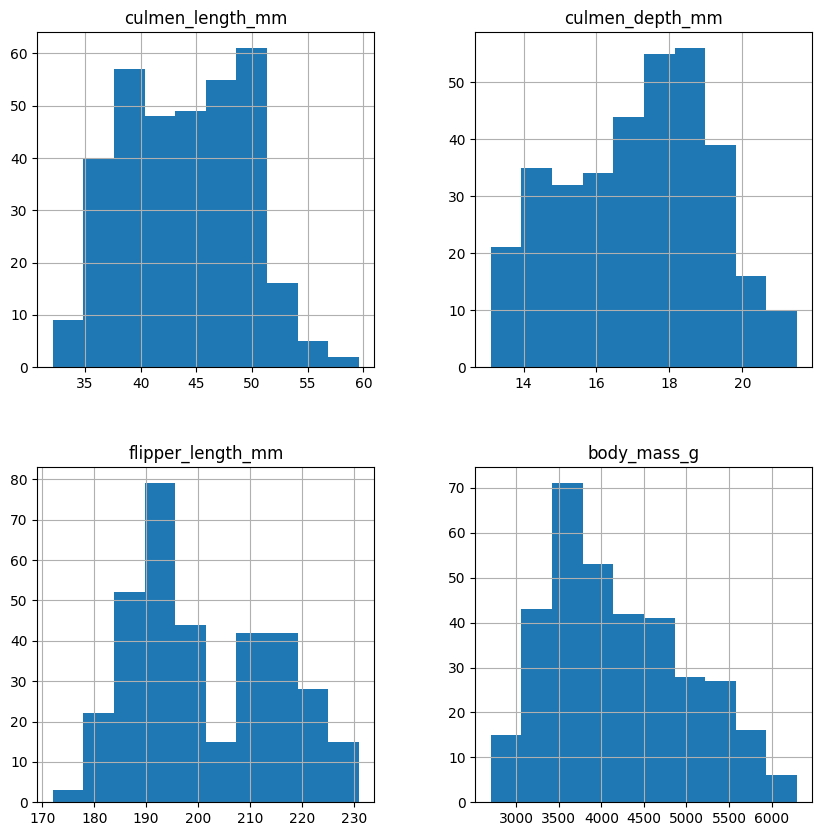

In [19]:
cols_num.hist(figsize=(10, 10))

### 이상치

<Axes: >

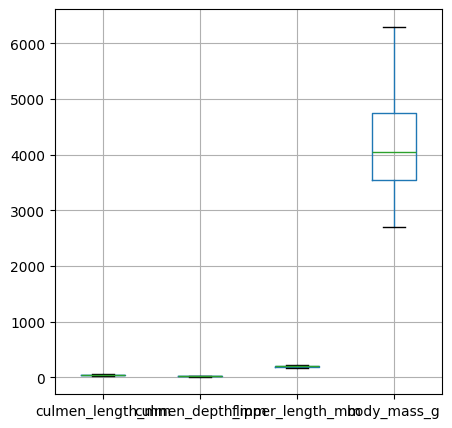

In [20]:
# 박스 플롯
cols_num.boxplot(figsize=(5, 5))

/Users/dusanbaek/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dusanbaek/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/dusanbaek/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dusanbaek/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:632: F

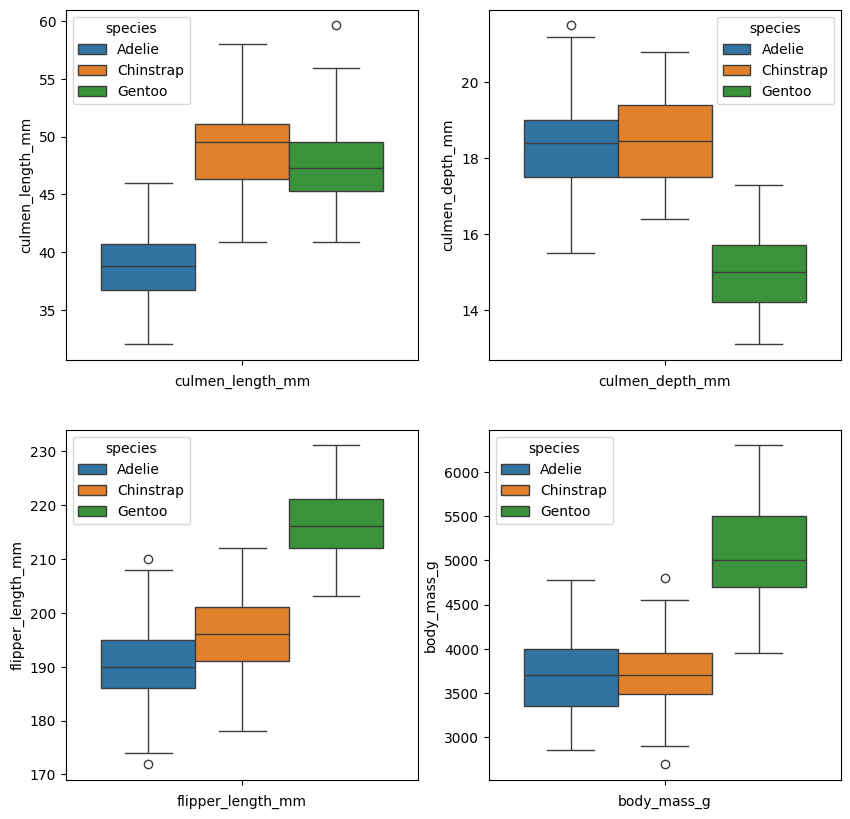

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()
for i, col in enumerate(cols_num.columns):
  sns.boxplot(y=col, data=cols_num, hue=df['species'], ax=ax[i])
  ax[i].set_xlabel(col)
plt.show()

In [22]:
# 데이터 분리, 결측치, 인코딩, 학습

## 2. 데이터 분리

In [23]:
from sklearn.model_selection import train_test_split

# 8:2로 나누고 종별로 균등하게 맞춰준다
train, test = train_test_split(df, test_size=0.2, random_state= 42, stratify=df['species'])
train.shape, test.shape

((275, 7), (69, 7))

### 결측치 처리

In [24]:
train.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

<Axes: >

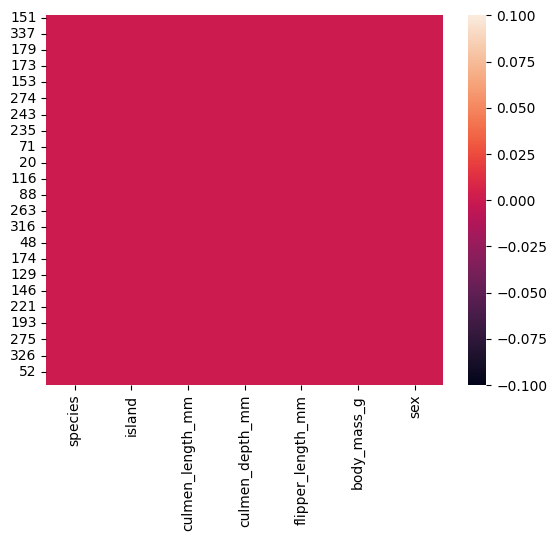

In [25]:
# sns.heatmap(train.isna())
sns.heatmap(test.isna())

In [26]:
# 결측치가 몇개 없으므로 그냥 버린다
train = train.dropna()

### X, y 분리

In [27]:
X_train = train.drop('species', axis=1)
y_train = train['species']

X_train.shape, y_train.shape

((265, 6), (265,))

In [28]:
from sklearn.preprocessing import OrdinalEncoder

# 독립 변수 + 범주형 변수에 대해서는 ordinal encoder를 보통 써줌.
# 이건 순서가 있다고 판단하는 건데 현재 상황에서는 크게 영향을 안 미쳐서 상관 없음.
oe = OrdinalEncoder()
X_train[['island', 'sex']] = oe.fit_transform(X_train[['island', 'sex']])
X_train.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
98,1.0,33.1,16.1,178.0,2900.0,1.0
114,0.0,39.6,20.7,191.0,3900.0,1.0
118,2.0,35.7,17.0,189.0,3350.0,1.0
303,0.0,50.0,15.9,224.0,5350.0,2.0
343,0.0,49.9,16.1,213.0,5400.0,2.0


In [29]:
from sklearn.preprocessing import LabelEncoder

# 종속 변수 (타겟 변수) + 범주형 변수의 경우 label encoder를 써줌.
# fit 이 있고 없고의 차이는 훈련 데이터냐, 테스트 데이터냐. 지금의 경우는 훈련이므로 fit을 사용.
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0,
       0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2,
       0, 0, 1, 2, 0, 1, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 0, 0, 1, 2, 0,
       0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0,
       1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 1, 0, 1,
       0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2,
       0, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 1,
       2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0,
       1])

### 스케일링

In [30]:
from sklearn.preprocessing import RobustScaler

# 이상치에 영향을 많이 받지 않는 스케일러인 robust scaler를 사용

rs = RobustScaler()
X_train_s = rs.fit_transform(X_train)

X_train_s


array([[ 0.        , -1.31868132, -0.375     , -0.82608696, -0.92      ,
        -1.        ],
       [-1.        , -0.6043956 ,  1.0625    , -0.26086957, -0.12      ,
        -1.        ],
       [ 1.        , -1.03296703, -0.09375   , -0.34782609, -0.56      ,
        -1.        ],
       ...,
       [ 1.        , -0.25274725,  0.375     , -0.08695652,  0.16      ,
         0.        ],
       [ 1.        , -0.92307692,  0.46875   , -0.43478261, -0.2       ,
        -1.        ],
       [ 0.        ,  0.62637363,  0.53125   ,  0.56521739,  0.04      ,
         0.        ]])

## 3. 모델 학습

In [31]:
print(X_train_s.shape, y_train.shape)
print(type(X_train_s), type(y_train))

(265, 6) (265,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### 트리 알고리즘

In [32]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, max_depth= 3)
clf.fit(X_train_s, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

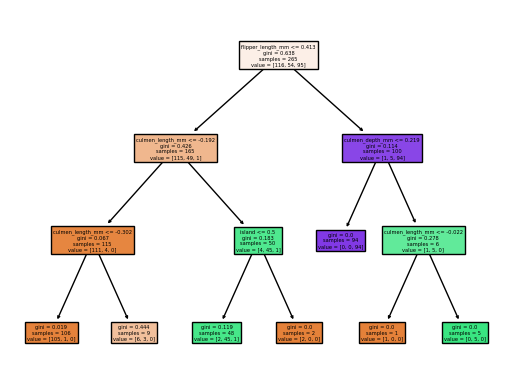

In [34]:
from sklearn.tree import plot_tree

plot_tree(clf, filled= True, feature_names= X_train.columns)
plt.show()

accuracy_score: 0.9710144927536232
precision: 0.9760683760683762
recall_score: 0.9650793650793651
f1_score: 0.9700072621641249


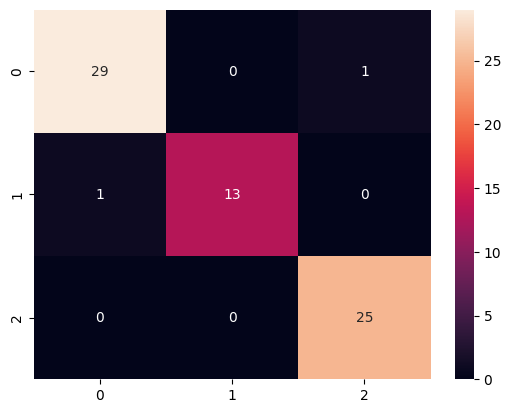

In [35]:
# 테스트 데이터 전처리
# 평가

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

test = test.dropna()
X_test = test.drop('species', axis=1)
y_test = test['species']

# 테스트 데이터들은 fit_transform이 아닌 그냥 transform을 적용
X_test[['island', 'sex']] = oe.transform(X_test[['island', 'sex']])
y_test = le.transform(y_test)

# 독립 변수에는 스케일러 한번 더 때려주고
X_test_s = rs.transform(X_test)

# 결과 예측 후
y_pred = clf.predict(X_test_s)

# 시각화
print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred, average= "macro")}')
print(f'recall_score: {recall_score(y_test, y_pred, average= "macro")}')
print(f'f1_score: {f1_score(y_test, y_pred, average= "macro")}')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

## 랜덤 포레스트

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf_r = RandomForestClassifier(n_estimators= 100, random_state=42)
clf_r.fit(X_train_s, y_train)

RandomForestClassifier(random_state=42)

accuracy_score: 0.9855072463768116
precision: 0.9777777777777779
recall_score: 0.9888888888888889
f1_score: 0.9828560296123126


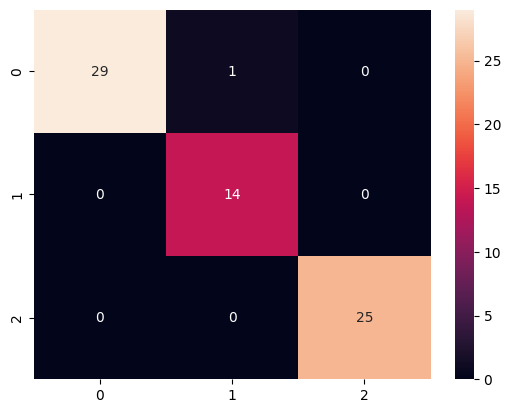

In [37]:
y_pred = clf_r.predict(X_test_s)

print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'precision: {precision_score(y_test, y_pred, average= "macro")}')
print(f'recall_score: {recall_score(y_test, y_pred, average= "macro")}')
print(f'f1_score: {f1_score(y_test, y_pred, average= "macro")}')

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()